In [19]:
from pathlib import Path
import PIL
import cv2
from ufish.api import UFish
from cellpose import models
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist
from skimage.measure import regionprops, label
from skimage.morphology import remove_small_objects
from skimage.morphology import diamond, ball, dilation
from skimage.segmentation import watershed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

# Cancer pathology samples

# Load the image
data_dir = "./data/"
img_paths = {
    path.stem: path for path in Path(data_dir).glob("*.TIF")
}

print(img_paths)

images = {
    name: np.array(PIL.Image.open(path))
    for name, path in img_paths.items()
}

# initialize cellpose model
cp = models.Cellpose(gpu=False, model_type="nuclei")

def segment_cells(img, ch=-1, area_threshold=1000, centroid_distance_threshold=100, 
                  axis_ratio_threshold=0.9):
    """Segment cells using cellpose model and remove masks based on centroid distance and axis ratio."""
    img = img[:, :, ch]
    masks, _, _, _ = cp.eval(img, diameter=70, flow_threshold=1.2, cellprob_threshold=-1.0)
    masks = remove_small_objects(masks, min_size=1000)
    labeled_masks = label(masks)
    props = regionprops(labeled_masks)
    centroids = np.array([prop.centroid for prop in props])
    distances = cdist(centroids, centroids)
    for i in range(len(props)):
        if props[i].area > area_threshold:
            axis_ratio = props[i].minor_axis_length / props[i].major_axis_length
            distances_to_other_centroids = distances[i, :]
            distances_to_other_centroids[i] = np.inf
            if np.min(distances_to_other_centroids) < centroid_distance_threshold or axis_ratio < axis_ratio_threshold:
                masks[labeled_masks == props[i].label] = 0
    return masks

import cv2
def extract_cell_rois(image, masks):
    cell_rois = []
    for ch in range(image.shape[2]):
        ch_image = image[:, :, ch]
        binary_mask = (masks > 0).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        channel_cell_rois = []
        channel_cell_masks = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cell_roi = ch_image[y:y+h, x:x+w]
            cell_mask = binary_mask[y:y+h, x:x+w]

            scale_factor = min(128 / h, 128 / w)
            if scale_factor < 1:
                new_w, new_h = int(w * scale_factor), int(h * scale_factor)
                cell_roi = cv2.resize(cell_roi, (new_w, new_h))
                cell_mask = cv2.resize(cell_mask, (new_w, new_h))
                w, h = new_w, new_h

            padded_roi = np.zeros((128, 128), dtype=ch_image.dtype)
            padded_mask = np.zeros((128, 128), dtype=binary_mask.dtype)

            start_y = (128 - h) // 2
            start_x = (128 - w) // 2

            padded_roi[start_y:start_y+h, start_x:start_x+w] = cell_roi
            padded_mask[start_y:start_y+h, start_x:start_x+w] = cell_mask

            channel_cell_rois.append(padded_roi)
            if ch == image.shape[2] - 1: 
                channel_cell_masks.append(padded_mask)
        cell_rois.append(channel_cell_rois)
        if ch == image.shape[2] - 1: 
            cell_masks = channel_cell_masks

    return np.array(cell_rois), np.array(cell_masks)


def cc_sub(im: np.ndarray, seed: np.ndarray, connectivity=2) -> np.ndarray:
    """Subtract the Connected Components in image which overlap with seed.

    :param im: mask image to be subtract CC.
    :param seed: mask image.
    :param connectivity: connectivity to calculate label, see:
    https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label

    :return: CC in im without overlap with seed.
    """
    lb = label(seed, connectivity=connectivity)
    w = watershed(im, markers=lb, connectivity=connectivity, mask=im)
    o = w > 1
    d = im ^ o
    return d

def mask_sub(oriangal: np.ndarray,
             masks: list[np.ndarray],
             ) -> np.ndarray:
    o = oriangal
    for m in masks:
        o = cc_sub(o, m)
    return o

def coordinates_to_mask(points: np.ndarray, shape: tuple or None = None) -> np.ndarray:
    points = points.astype(np.int64)
    dim_max = tuple([points[:, i].max()+1 for i in range(points.shape[1])])
    if shape is None:
        shape = dim_max
    else:
        assert len(shape) == points.shape[1]
        shape = tuple([shape[i] or dim_max[i] for i in range(points.shape[1])])
    arr = np.zeros(shape, dtype=np.bool_)
    ix = tuple(points[:, d] for d in range(points.shape[1]))
    arr[ix] = True  
    return arr

def cc_centroids(mask: np.ndarray) -> np.ndarray:
    if mask.dtype == bool:
        mask = label(mask.astype(int)) 
    ccs = regionprops(mask)
    centroids, labels = [], []
    for cc in ccs:
        centroids.append(cc.centroid)
        labels.append(cc.label)
    return np.array(centroids), np.array(labels)

def spots_sub(spots_a: np.ndarray, spots_b: np.ndarray, radius: int):
    assert spots_a.shape[1] == spots_b.shape[1]
    dim = spots_a.shape[1]
    assert 2 <= dim <= 3
    shape = tuple([max([int(pts[:, i].max()) for pts in [spots_a, spots_b]]) + 1
                   for i in range(dim)])
    mask_a = coordinates_to_mask(spots_a, shape)
    se = diamond(radius) if dim == 2 else ball(radius)
    mask_a = dilation(mask_a, se)
    mask_b = coordinates_to_mask(spots_b, shape)
    res_mask = mask_sub(mask_a, [mask_b])
    return cc_centroids(res_mask)[0]


# initialize ufish model
uf = UFish()
uf.load_weights("/home/qzhang/ufish/finetune/dnafish/v1.0.1-DNAFISH_model.pth")
# weights link: https://huggingface.co/GangCaoLab/U-FISH/blob/main/finetune_models/v1.0.1-DNAFISH_model.pth

def call_spots(img, ch=[0, 1], intensity_threshold=0.5):
    """Call spots using ufish model."""
    spots_list = []
    for c in ch:
        spots, _ = uf.predict(img[:, :, c])
        spots = spots.values
        spots = spots[img[spots[:, 0], spots[:, 1], c] > intensity_threshold]
        spots_list.append(spots)
    return spots_list

def get_merge_spots(spots_list, max_dist=2.0, ch=[0, 1]):
    """Get the coordinates of all merged spots from multiple channels."""
    spots_ch1 = spots_list[ch[0]]
    spots_ch2 = spots_list[ch[1]]
    tree = KDTree(spots_ch1)
    dist, ind = tree.query(spots_ch2, k=1)
    merge_spots = spots_ch1[ind[dist < max_dist]]
    if len(ch) == 3:
        spots_ch3 = spots_list[ch[2]]
        tree = KDTree(merge_spots)
        dist, ind = tree.query(spots_ch3, k=1)
        merge_spots = merge_spots[ind[dist < max_dist]]
    return merge_spots

def assign_spots(
        spots: np.ndarray,
        mask: np.ndarray,
        dist_th: float,
        ) -> np.ndarray:
    assert len(mask.shape) in (2, 3)
    centers, labels = cc_centroids(mask)
    assert centers.shape[1] == len(mask.shape)
    pos_each_axes = np.where(mask > 0)
    pos_ = np.c_[pos_each_axes]
    tree = KDTree(pos_)
    dist, idx = tree.query(spots)
    dist, idx = np.concatenate(dist), np.concatenate(idx)
    clost = pos_[idx, :]
    if centers.shape[1] == 2:
        mask_val = mask[clost[:, 0], clost[:, 1]]
    else:
        mask_val = mask[clost[:, 0], clost[:, 1], clost[:, 2]]
    res = mask_val
    res[dist > dist_th] = 0
    return res    
   
def change_ch(img):
    tmp = np.swapaxes(img,0, 1)
    tmp = np.swapaxes(tmp,1, 3)
    tmp = np.swapaxes(tmp,1, 2)
    return tmp
    
def pipeline(img, signal_channels=[0, 1]):
    print(f"Processing image:")
    print(f"Image shape: {img.shape}")
    print("Step 1: segment cells")
    masks = segment_cells(img)

    print("Step 2: extract ROIs")
    cell_rois, cell_masks = extract_cell_rois(img, masks)

    print("Step 3: call spots and assign spots")
    table = []
    cell_signals = []
    cell_rois = change_ch(cell_rois)
    for w in range(cell_rois.shape[0]):

        spots = call_spots(cell_rois[w], ch=signal_channels, intensity_threshold=0.1)
        
        signals = {}
        if len(signal_channels) == 1:
            signals = {f"ch{signal_channels[0]+1}": spots[0]}

        for chs in combinations(signal_channels, 2):
            if spots[chs[0]].size == 0 or spots[chs[1]].size == 0:
                continue
            merged = get_merge_spots(spots, max_dist=5, ch=chs)
            if len(merged) > 0: # check if merged is not empty
                name = f"ch{chs[0]+1}+ch{chs[1]+1}"
                signals[name] = merged
                for ch in chs: # subtract spots
                    name = f"ch{ch+1}"
                    sps = spots[ch]
                    sps = spots_sub(sps, merged, radius=3)
                    signals[name] = sps
            else:
                for ch in chs:
                    name = f"ch{ch+1}"
                    signals[name] = spots[ch]
                    
        if len(signal_channels) == 3:
            if spots[0].size == 0 or spots[1].size == 0 or spots[2].size == 0:
                continue
            merged = get_merge_spots(spots, max_dist=5, ch=signal_channels)
            if len(merged) > 0:
                name = f"ch1+ch2+ch3"
                signals[name] = merged
                for name in ["ch1+ch2", "ch1+ch3", "ch2+ch3"]: # subtract spots
                    sps = signals[name]
                    sps = spots_sub(np.array(sps), np.array(merged), radius=3)
                    signals[name] = sps
            else:
                for ch in signal_channels:
                    name = f"ch{ch+1}"
                    signals[name] = spots[ch]
        assigns = {}
        for name, spots in signals.items():
            try:
                assigns[name] = assign_spots(spots, cell_masks[w], 30)
            except Exception as e:
                print(f"No spots: {e}. Skipping this assignment.")
                continue
        df = {key: sum(value) for key, value in assigns.items() if isinstance(value, np.ndarray)}    
        df["cell_id"] = f'cell-{w}'
        last_key = list(df.keys())[-1]
        last_value = df.pop(last_key)
        df = {last_key: last_value, **df}
        table.append(df)
        cell_signals.append(signals)
          
    return pd.DataFrame(table).fillna(0), cell_rois, cell_masks, cell_signals

{'Dual fusion': PosixPath('data/Dual fusion.TIF'), 'separation probe': PosixPath('data/separation probe.TIF'), 'Trisomy 8': PosixPath('data/Trisomy 8.TIF')}


2024-03-24 20:00:30.706 | INFO     | ufish.api:init_model:70 - Initializing ufish model with kwargs: {}
2024-03-24 20:00:30.706 | INFO     | ufish.api:init_model:72 - Number of parameters: 162959
2024-03-24 20:00:30.728 | INFO     | ufish.api:init_model:78 - CUDA is available, using GPU.
2024-03-24 20:00:30.728 | INFO     | ufish.api:_load_pth_file:232 - Loading weights from /home/qzhang/ufish/finetune/dnafish/v1.0.1-DNAFISH_model.pth


In [8]:
img = images["Trisomy 8"]

_, cell_rois, cell_masks, cell_signals = pipeline(img, signal_channels=[0])


Processing image:
Image shape: (3000, 4096, 3)
Step 1: segment cells


2024-03-24 19:51:30.826 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:30.829 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:30.862 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:30.862 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:30.872 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:30.873 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:30.882 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:30.883 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:30.891 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:30.892 | INFO     | ufish.api:p

Step 2: extract ROIs
Step 3: call spots and assign spots


2024-03-24 19:51:30.992 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:30.993 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:31.002 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:31.003 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:31.012 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:31.013 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:31.022 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:31.023 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:31.032 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:31.033 | INFO     | ufish.api:p

No spots: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.. Skipping this assignment.


2024-03-24 19:51:31.567 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:31.568 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:31.578 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:31.579 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:31.589 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:31.590 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:31.598 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:31.599 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 19:51:31.609 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 19:51:31.609 | INFO     | ufish.api:p

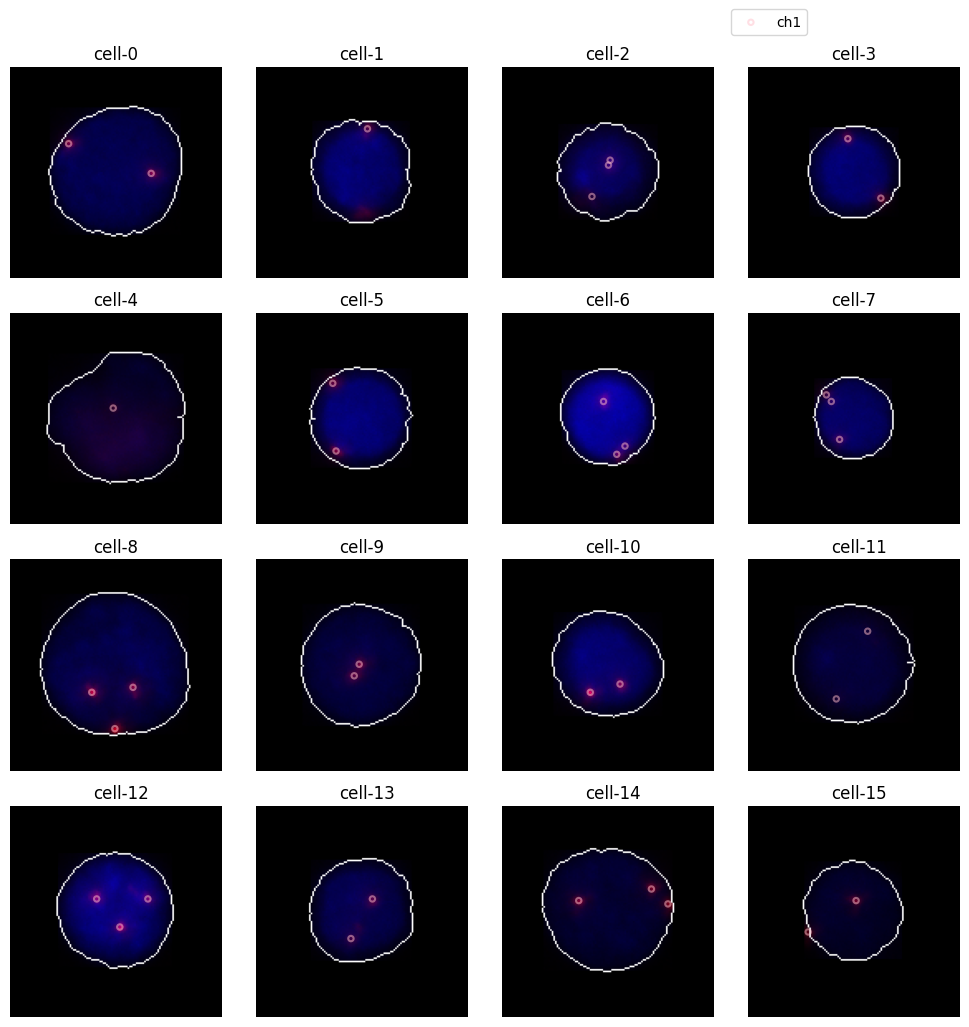

In [47]:
def plot_cell_and_spots(ax, img, mask, signals, colors):
    bmask = mask > 0
    edges = dilation(bmask>0, diamond(1)) & ~bmask
    img = img.copy()
    img[edges, :] = 255 
    ax.imshow(img)
    for name, spot in signals.items():
        ax.scatter(spot[:, 1], spot[:, 0], s=15, edgecolors=colors[name], facecolors="None", linewidths=1, label=name)
        
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    plot_cell_and_spots(ax, cell_rois[i], cell_masks[i], cell_signals[i], {"ch1": "pink", "ch2": "cyan", "ch1+ch2": "yellow"})
    ax.text(50, -5, f"cell-{i}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.legend(loc="upper center", bbox_to_anchor=(0.1, 4.8), ncols=1, fontsize=12)
plt.show()

In [50]:
img = images["Dual fusion"]

_, cell_rois, cell_masks, cell_signals = pipeline(img, signal_channels=[0, 1])


Processing image:
Image shape: (3000, 4096, 3)
Step 1: segment cells


2024-03-24 20:14:11.298 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:14:11.301 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:14:11.335 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:14:11.337 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:14:11.352 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:14:11.353 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:14:11.361 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:14:11.361 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:14:11.379 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:14:11.380 | INFO     | ufish.api:p

Step 2: extract ROIs
Step 3: call spots and assign spots


2024-03-24 20:14:11.451 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:14:11.459 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:14:11.460 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:14:11.473 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:14:11.474 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:14:11.482 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:14:11.483 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:14:11.498 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:14:11.499 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:14:11.506 | INFO     | ufish.api:predic

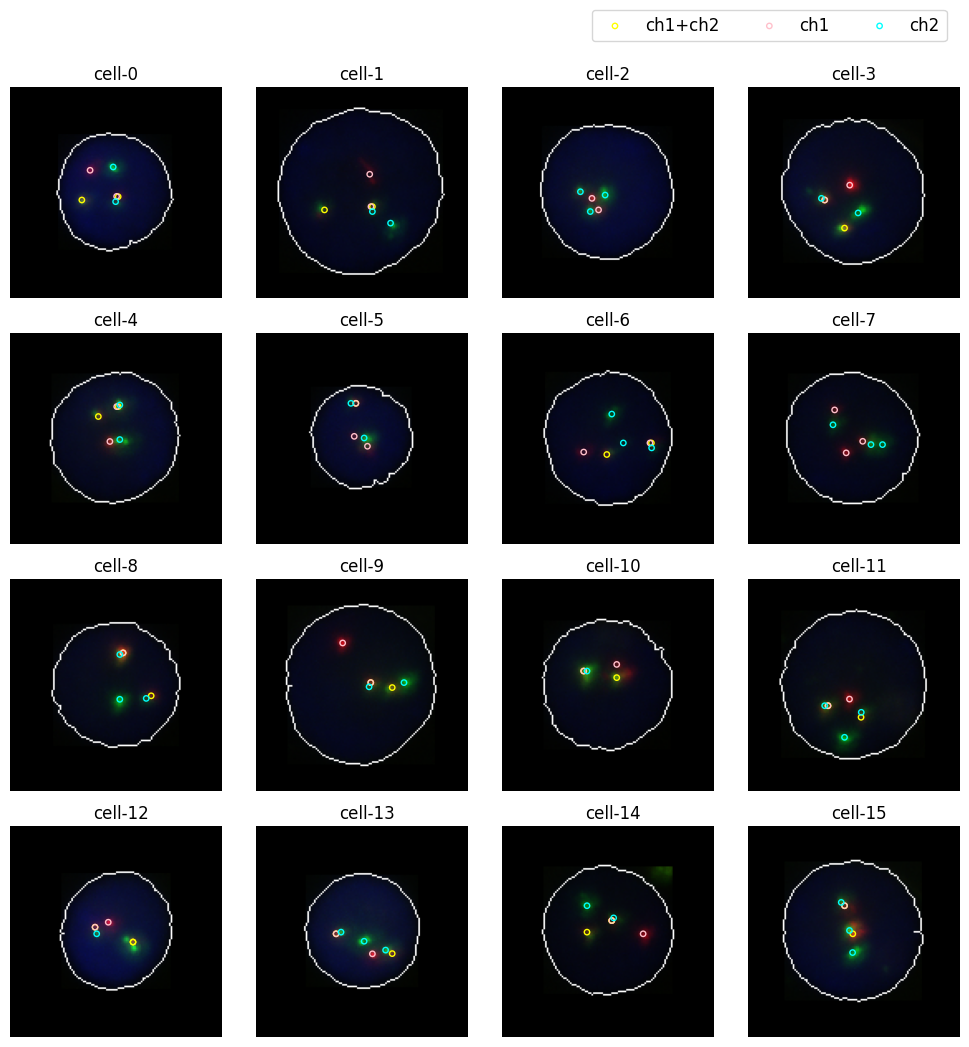

In [60]:
def plot_cell_and_spots(ax, img, mask, signals, colors):
    bmask = mask > 0
    edges = dilation(bmask>0, diamond(1)) & ~bmask
    img = img.copy()
    img[edges, :] = 255 
    ax.imshow(img)
    for name, spot in signals.items():
        ax.scatter(spot[:, 1], spot[:, 0], s=15, edgecolors=colors[name], facecolors="None", linewidths=1, label=name)
        
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    plot_cell_and_spots(ax, cell_rois[i], cell_masks[i], cell_signals[i], {"ch1": "pink", "ch2": "cyan", "ch1+ch2": "yellow"})
    ax.text(50, -5, f"cell-{i}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.legend(loc="upper center", bbox_to_anchor=(0.1, 4.9), ncols=3, fontsize=12)
plt.show()

In [61]:
img = images["separation probe"]

_, cell_rois, cell_masks, cell_signals = pipeline(img, signal_channels=[0, 1])


Processing image:
Image shape: (3000, 4096, 3)
Step 1: segment cells


2024-03-24 20:23:04.812 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:04.814 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:23:04.845 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:04.845 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:23:04.866 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:04.867 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:23:04.874 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:04.875 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:23:04.895 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:04.896 | INFO     | ufish.api:p

Step 2: extract ROIs
Step 3: call spots and assign spots


2024-03-24 20:23:04.985 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:04.986 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:23:05.005 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:05.005 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:23:05.013 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:05.014 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:23:05.030 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:05.031 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-24 20:23:05.039 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-24 20:23:05.040 | INFO     | ufish.api:p

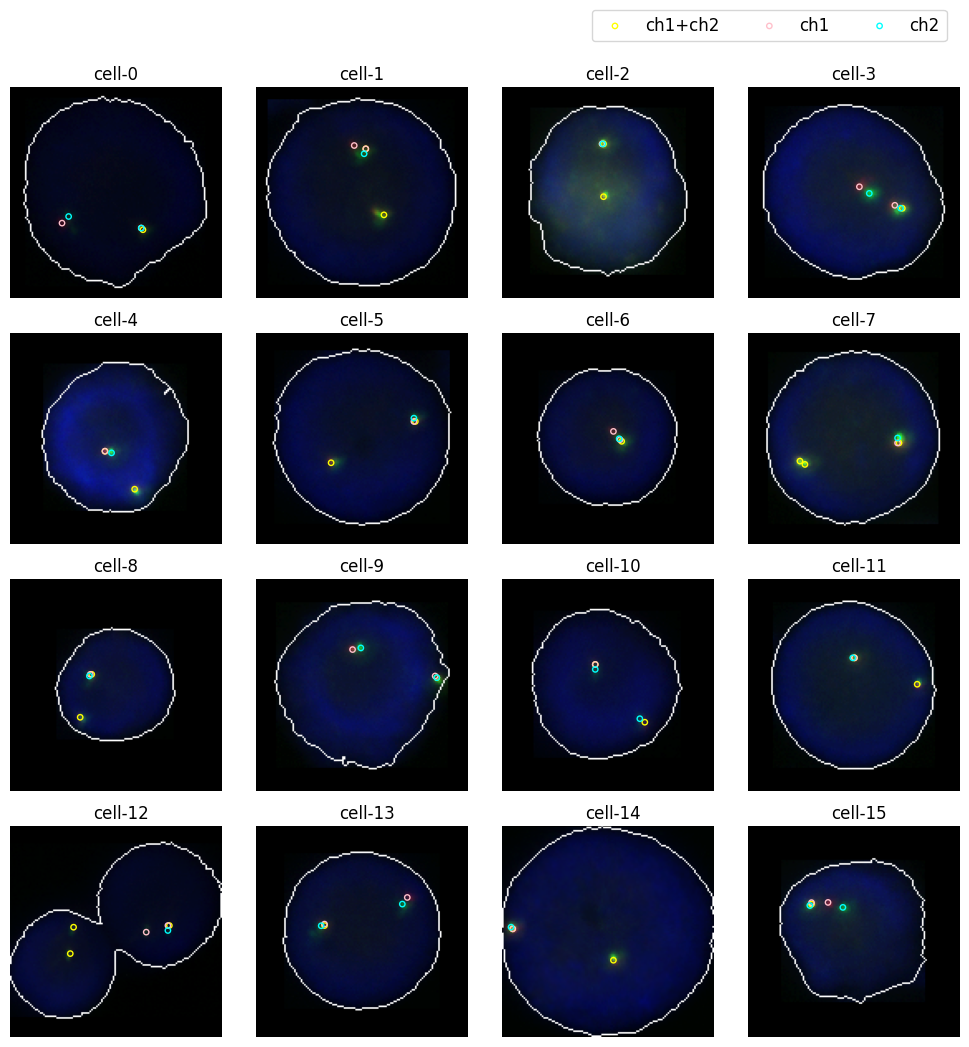

In [62]:
def plot_cell_and_spots(ax, img, mask, signals, colors):
    bmask = mask > 0
    edges = dilation(bmask>0, diamond(1)) & ~bmask
    img = img.copy()
    img[edges, :] = 255 
    ax.imshow(img)
    for name, spot in signals.items():
        ax.scatter(spot[:, 1], spot[:, 0], s=15, edgecolors=colors[name], facecolors="None", linewidths=1, label=name)
        
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    plot_cell_and_spots(ax, cell_rois[i], cell_masks[i], cell_signals[i], {"ch1": "pink", "ch2": "cyan", "ch1+ch2": "yellow"})
    ax.text(50, -5, f"cell-{i}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.legend(loc="upper center", bbox_to_anchor=(0.1, 4.9), ncols=3, fontsize=12)
plt.show()